In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cd drive/MyDrive/Named-Entity-Recognition_DeepLearning-keras/


# First we will do Entity Tag preiction , then Parts of Speech Tagging/Prediction

## Entity Tagging

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

data = pd.read_csv("drive/MyDrive/ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1) #dont need parts of speech tags 
data = data.fillna(method="ffill")
data.tail(30)

,Sentence #,Word,Tag
1048545,Sentence: 47957,Two,O
1048546,Sentence: 47957,more,O
1048547,Sentence: 47957,landed,O
1048548,Sentence: 47957,in,O
1048549,Sentence: 47957,fields,O
1048550,Sentence: 47957,belonging,O
1048551,Sentence: 47957,to,O
1048552,Sentence: 47957,a,O
1048553,Sentence: 47957,nearby,O
1048554,Sentence: 47957,village,O


In [ ]:
'''
geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time indicator
art = Artifact
eve = Event
nat = Natural Phenomenon
'''
data['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('i am eating Apple ')
displacy.render(text, style = 'ent', jupyter=True)

In [ ]:
data['Sentence #'].value_counts()

Sentence: 22480    104
Sentence: 33481     81
Sentence: 40153     73
Sentence: 21167     72
Sentence: 21776     70
                  ... 
Sentence: 4810       2
Sentence: 37093      2
Sentence: 39874      2
Sentence: 38917      1
Sentence: 8412       1
Name: Sentence #, Length: 47959, dtype: int64

## we have 47958 sentences in our dataset, 35179 different words and 17 different named entities (Tags).

In [ ]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35179

In [ ]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

## this Class is in charge of converting every sentence with its named entities (tags) into a list of tuples [(word, named entity), …]

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sent = getter.get_next()
for i in sent:
  print(i)

('Thousands', 'O')
('of', 'O')
('demonstrators', 'O')
('have', 'O')
('marched', 'O')
('through', 'O')
('London', 'B-geo')
('to', 'O')
('protest', 'O')
('the', 'O')
('war', 'O')
('in', 'O')
('Iraq', 'B-geo')
('and', 'O')
('demand', 'O')
('the', 'O')
('withdrawal', 'O')
('of', 'O')
('British', 'B-gpe')
('troops', 'O')
('from', 'O')
('that', 'O')
('country', 'O')
('.', 'O')


In [ ]:
sentences = getter.sentences
print(len(sentences))

47959


In [ ]:
sentences[1]

[('Iranian', 'B-gpe'),
 ('officials', 'O'),
 ('say', 'O'),
 ('they', 'O'),
 ('expect', 'O'),
 ('to', 'O'),
 ('get', 'O'),
 ('access', 'O'),
 ('to', 'O'),
 ('sealed', 'O'),
 ('sensitive', 'O'),
 ('parts', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('plant', 'O'),
 ('Wednesday', 'B-tim'),
 (',', 'O'),
 ('after', 'O'),
 ('an', 'O'),
 ('IAEA', 'B-org'),
 ('surveillance', 'O'),
 ('system', 'O'),
 ('begins', 'O'),
 ('functioning', 'O'),
 ('.', 'O')]

In [ ]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


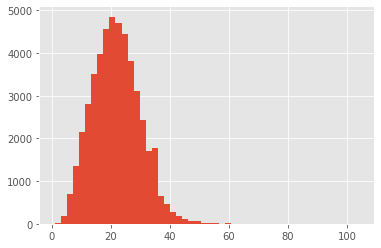

In [ ]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

## so the longest sentence has 140 words in it and we can see that almost all of the sentences have less than 60 words in them.

In [ ]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['London'])
print(tags2index['B-geo'])

26192
0


In [ ]:
words2index_ner = words2index
tags2index_ner = tags2index

## Lets visualise words to index and vice versa mappings

In [ ]:
data['Word_idx'] = data['Word'].map(words2index)
data['Tag_idx'] = data['Tag'].map(tags2index)
data.head()

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,O,15032,10
1,Sentence: 1,of,O,24305,10
2,Sentence: 1,demonstrators,O,25262,10
3,Sentence: 1,have,O,9647,10
4,Sentence: 1,marched,O,17905,10


In [ ]:
# Groupby and collect columns
data_group = data.groupby(
['Sentence #'],as_index=False
)['Word', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
# Visualise data
data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[15032, 24305, 25262, 9647, 17905, 19338, 2619...","[10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[21601, 2577, 26276, 34153, 8441, 23556, 28190...","[6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[7922, 11659, 24885, 14181, 13304, 9556, 24118...","[10, 10, 9, 10, 10, 10, 10, 10, 0, 10, 10, 10,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[16665, 28393, 19934, 33990, 5304, 33956, 1559...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[26693, 17427, 18596, 18241, 29263, 9436, 3077...","[0, 10, 10, 7, 2, 10, 9, 10, 0, 10, 6, 10, 6, ..."


## One of the biggest benefits of this approach is that we dont need any feature engineering; all we need is the sentences and its labeled words, the rest of the work is carried on by ELMo embeddings. In order to feed our sentences into a LSTM network, they all need to be the same size. looking at the distribution graph, we can set the length of all sentences to 50 and add a generic word for the empty spaces; this process is called padding.(another reason that 50 is a good number is that my laptop cannot handle longer sentences).

In [ ]:
max_len = 50
X = [[w[0] for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

## and the same applies for the named entities but we need to map our labels to numbers this time:

In [ ]:
#from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([ 6, 10, 10,  7,  2,  2,  2, 10, 10, 10, 10, 10,  9, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
      dtype=int32)

In [ ]:
y_ner = y

In [ ]:
# from tensorflow.keras.utils import to_categorical
# y = [to_categorical(i, num_classes=n_tags) for i in y]

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2021)


In [ ]:
print(len(X_tr))
print(len(X_te))
print(len(y_tr))

43163
4796
43163


In [ ]:
y_tr.shape

(43163, 50)

In [ ]:
#limit = 5000
#start,res = 32,32
#cn = 1
#while res<=limit:
#  res = start * cn
#  cn += 1
#  if res>limit:
#    res = start * (cn-2)
#print(res)

In [ ]:
#5024-32

In [ ]:
limit = 4992
X_tr = X_tr[:limit]
y_tr = y_tr[:limit]

In [ ]:
print(len(new_X))
print(len(X_tr))
print(len(X_te))

47959
4992
4796


In [ ]:
# !pip install tensorflow==1.15
# !pip install "tensorflow_hub>=0.6.0"
# !pip3 install tensorflow_text==1.15

In [ ]:
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()
print(tf1.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
2.7.0


In [ ]:
batch_size = 32
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K
sess = tf.compat.v1.Session()
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
batch_size = 32
"""
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
"""
batch_size = 32
X_tr, X_val = X_tr[:140*batch_size], X_tr[-15*batch_size:]
y_tr, y_val = y_tr[:140*batch_size], y_tr[-15*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [ ]:
print(len(X_tr))
print(len(X_val))
print(len(y_val))


4480
480
480


In [ ]:
# training size full
print(y_val.shape)
print(y_tr.shape)

print(len(X_val))

(480, 50, 1)
(4480, 50, 1)
480


In [ ]:
# training size 5000
print(y_val.shape)
print(y_tr.shape)

print(len(X_val))

(480, 50, 1)
(4480, 50, 1)
480


In [ ]:
y_ner_tr=y_tr
y_ner_te = y_te
y_ner_val = y_val

### ELMo has a great understanding of the language because it’s trained on a massive dataset, ELMo embeddings are trained on the 1 Billion Word Benchmark. the training is called bidirectional language model (biLM) that can learn from the past and predict the next word in a sequence of words like a sentence. Let’s see how we can implement this approach.

In [ ]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.compat.v1.global_variables_initializer())
sess.run(tf.compat.v1.tables_initializer())

In [ ]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [ ]:
# embedding_hub = hub.KerasLayer("https://tfhub.dev/google/elmo/2",output_shape=(max_len, 1024),trainable=True)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [ ]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
tag_model = Model(input_text, out)
tag_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
tag_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 lambda (Lambda)                (32, None, 1024)     0           ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (32, None, 1024)     6295552     ['lambda[0][0]']                 
                                                                                                  
 bidirectional_1 (Bidirectional  (32, None, 1024)    6295552     ['bidirectional[0][0]']          
 )                                                                                            

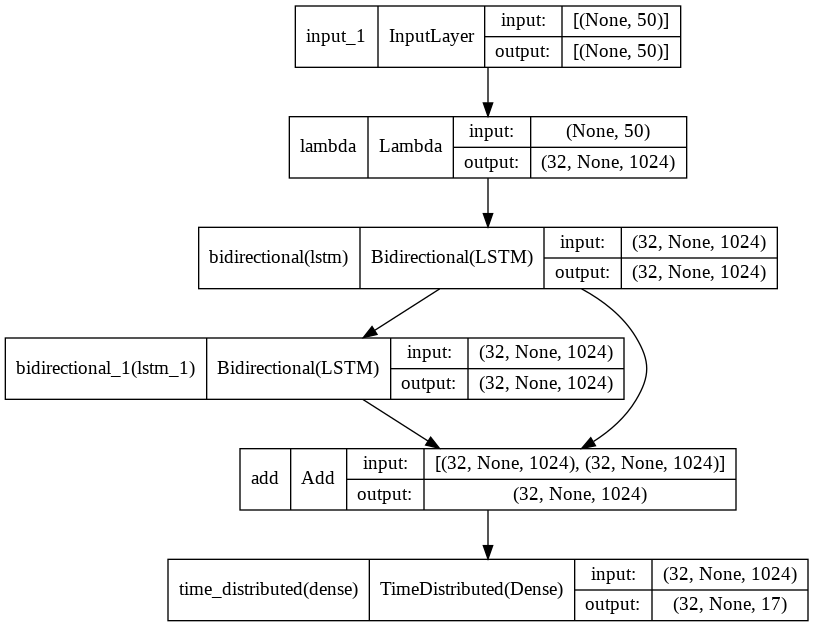

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(tag_model,'Elmo_tag.png',show_shapes= True)

In [ ]:
# pip install pydot

- __Embedding layer__ : We will specify the maximum length (50) of the padded sequences. After the network is trained, the embedding layer will transform each token into a vector of n dimensions.
- __Bidirectional LSTM__: Bidirectional lstm takes a recurrent layer (e.g. the first LSTM layer) as an argument. This layer takes the output from the previous embedding layer .
__We will use 2 Bi LSTM layers and residual connection to the first biLSTM__
- __TimeDistributed Layer__: We are dealing with Many to Many RNN Architecture, where we expect output from every input sequence. Here is an example, in the sequence (a1 →b1, a2 →b2…an →bn), a, and b are inputs and outputs of every sequence. The TimeDistributeDense layers allow Dense(fully-connected) operation across every output over every time-step. No using this layer will result in one final output.

In [ ]:
history = tag_model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=1, verbose=1)

Train on 4480 samples, validate on 480 samples
4480/4480 [==============================] - ETA: 0s - loss: 0.1333 - acc: 0.9650

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4480/4480 [==============================] - 68s 15ms/sample - loss: 0.1333 - acc: 0.9650 - val_loss: 0.0782 - val_acc: 0.9784


In [ ]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=f2b0a23e1b019f7f6f331f587b702bb45c6c70d3e3861a9935ae03446166b7a1
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
test_pred = tag_model.predict(np.array(X_te), verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])


In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 75.1%


In [ ]:
print(classification_report(test_labels, pred_labels))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        49
         eve       0.00      0.00      0.00        29
         geo       0.79      0.86      0.83      3682
         gpe       0.92      0.85      0.88      1637
         nat       0.00      0.00      0.00        17
         org       0.55      0.58      0.56      2022
         per       0.68      0.72      0.70      1687
         tim       0.82      0.72      0.77      2014

   micro avg       0.75      0.75      0.75     11137
   macro avg       0.47      0.47      0.47     11137
weighted avg       0.75      0.75      0.75     11137



In [ ]:
i = 395
p = tag_model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
Mr.            :B-per (B-per)
Azhari         :I-per (I-per)
told           :O     (O)
VOA            :O     (B-org)
reporter       :O     (O)
William        :B-per (B-org)
Eagle          :I-per (I-org)
that           :O     (O)
he             :O     (O)
expects        :O     (O)
the            :O     (O)
government     :O     (O)
to             :O     (O)
be             :O     (O)
completely     :O     (O)
relocated      :O     (O)
from           :O     (O)
Nairobi        :B-geo (B-geo)
,              :O     (O)
Kenya          :B-geo (B-geo)
to             :O     (O)
Somalia        :B-geo (B-geo)
by             :O     (O)
March          :B-tim (B-tim)
20th           :I-tim (I-tim)


### Visualising in spacy

In [ ]:
s = ''
for i in X_te[395]:
  s+=i+' '
s = s.rstrip()

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp(s)
displacy.render(text, style = 'ent', jupyter=True)

## Parts of Speech Prediction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

data = pd.read_csv("drive/MyDrive/ner_dataset.csv", encoding="latin1")
data = data.drop(['Tag'], axis =1) #dont need parts of speech tags 
data = data.fillna(method="ffill")
data.tail(30)

,Sentence #,Word,POS
1048545,Sentence: 47957,Two,CD
1048546,Sentence: 47957,more,JJR
1048547,Sentence: 47957,landed,VBD
1048548,Sentence: 47957,in,IN
1048549,Sentence: 47957,fields,NNS
1048550,Sentence: 47957,belonging,VBG
1048551,Sentence: 47957,to,TO
1048552,Sentence: 47957,a,DT
1048553,Sentence: 47957,nearby,JJ
1048554,Sentence: 47957,village,NN


In [ ]:
data['POS'].value_counts()

NN      145807
NNP     131426
IN      120996
DT       98454
JJ       78412
NNS      75840
.        47831
VBD      39379
,        32757
VBN      32328
VBZ      24960
CD       24695
VB       24211
CC       23716
TO       23061
RB       20252
VBG      19125
VBP      16158
PRP      13318
POS      11257
PRP$      8655
MD        6973
``        3728
WDT       3698
JJS       3034
JJR       2967
WP        2542
NNPS      2521
RP        2490
WRB       2184
$         1149
RBR       1055
:          795
RRB        679
LRB        678
EX         663
RBS        296
;          214
PDT        147
WP$         99
UH          24
FW           1
Name: POS, dtype: int64

In [ ]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35179

In [ ]:
tags = list(set(data["POS"].values))
n_tags = len(tags)
n_tags

42

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["POS"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'NNS'), ('of', 'IN'), ('demonstrators', 'NNS'), ('have', 'VBP'), ('marched', 'VBN'), ('through', 'IN'), ('London', 'NNP'), ('to', 'TO'), ('protest', 'VB'), ('the', 'DT'), ('war', 'NN'), ('in', 'IN'), ('Iraq', 'NNP'), ('and', 'CC'), ('demand', 'VB'), ('the', 'DT'), ('withdrawal', 'NN'), ('of', 'IN'), ('British', 'JJ'), ('troops', 'NNS'), ('from', 'IN'), ('that', 'DT'), ('country', 'NN'), ('.', '.')]


In [ ]:
sentences = getter.sentences
print(len(sentences))

47959


In [ ]:
sentences[0]

[('Thousands', 'NNS'),
 ('of', 'IN'),
 ('demonstrators', 'NNS'),
 ('have', 'VBP'),
 ('marched', 'VBN'),
 ('through', 'IN'),
 ('London', 'NNP'),
 ('to', 'TO'),
 ('protest', 'VB'),
 ('the', 'DT'),
 ('war', 'NN'),
 ('in', 'IN'),
 ('Iraq', 'NNP'),
 ('and', 'CC'),
 ('demand', 'VB'),
 ('the', 'DT'),
 ('withdrawal', 'NN'),
 ('of', 'IN'),
 ('British', 'JJ'),
 ('troops', 'NNS'),
 ('from', 'IN'),
 ('that', 'DT'),
 ('country', 'NN'),
 ('.', '.')]

In [ ]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


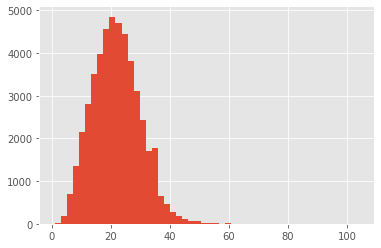

In [ ]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [ ]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['London'])
print(tags2index['NNS'])

26192
33


In [ ]:
words2index_pos = words2index
tags2index_pos = tags2index

In [ ]:
data['Word_idx'] = data['Word'].map(words2index)
data['POS_idx'] = data['POS'].map(tags2index)
data.head()

,Sentence #,Word,POS,Word_idx,POS_idx
0,Sentence: 1,Thousands,NNS,15032,33
1,Sentence: 1,of,IN,24305,16
2,Sentence: 1,demonstrators,NNS,25262,33
3,Sentence: 1,have,VBP,9647,36
4,Sentence: 1,marched,VBN,17905,15


In [ ]:
df_ner = data_group
df_ner.head()

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[15032, 24305, 25262, 9647, 17905, 19338, 2619...","[10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[21601, 2577, 26276, 34153, 8441, 23556, 28190...","[6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[7922, 11659, 24885, 14181, 13304, 9556, 24118...","[10, 10, 9, 10, 10, 10, 10, 10, 0, 10, 10, 10,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[16665, 28393, 19934, 33990, 5304, 33956, 1559...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[26693, 17427, 18596, 18241, 29263, 9436, 3077...","[0, 10, 10, 7, 2, 10, 9, 10, 0, 10, 6, 10, 6, ..."


In [ ]:
# Groupby and collect columns
data_group = data.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Word_idx', 'POS_idx'].agg(lambda x: list(x))
# Visualise data
data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,Sentence #,Word,POS,Word_idx,POS_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[15032, 24305, 25262, 9647, 17905, 19338, 2619...","[33, 16, 33, 36, 15, 16, 28, 0, 5, 20, 41, 16,..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[21601, 2577, 26276, 34153, 8441, 23556, 28190...","[25, 33, 36, 14, 36, 0, 5, 41, 0, 25, 25, 33, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[7922, 11659, 24885, 14181, 13304, 9556, 24118...","[41, 33, 28, 19, 25, 33, 16, 20, 28, 25, 41, 1..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[16665, 28393, 19934, 33990, 5304, 33956, 1559...","[14, 19, 16, 20, 41, 25, 41, 16, 41, 33, 37]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[26693, 17427, 18596, 18241, 29263, 9436, 3077...","[28, 41, 41, 28, 28, 19, 28, 18, 28, 18, 25, 4..."


In [ ]:
df_pos = data_group
df_pos.head()

,Sentence #,Word,POS,Word_idx,POS_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[15032, 24305, 25262, 9647, 17905, 19338, 2619...","[33, 16, 33, 36, 15, 16, 28, 0, 5, 20, 41, 16,..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[21601, 2577, 26276, 34153, 8441, 23556, 28190...","[25, 33, 36, 14, 36, 0, 5, 41, 0, 25, 25, 33, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[7922, 11659, 24885, 14181, 13304, 9556, 24118...","[41, 33, 28, 19, 25, 33, 16, 20, 28, 25, 41, 1..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[16665, 28393, 19934, 33990, 5304, 33956, 1559...","[14, 19, 16, 20, 41, 25, 41, 16, 41, 33, 37]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[26693, 17427, 18596, 18241, 29263, 9436, 3077...","[28, 41, 41, 28, 28, 19, 28, 18, 28, 18, 25, 4..."


In [ ]:
print(df_ner.shape, df_pos.shape)

(47959, 5) (47959, 5)


In [ ]:
df= df_ner
df['POS'] =df_pos['POS']
df['POS_idx'] = df_pos['POS_idx']

In [ ]:
df.head()

,Sentence #,Word,Tag,Word_idx,Tag_idx,POS,POS_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[15032, 24305, 25262, 9647, 17905, 19338, 2619...","[10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[33, 16, 33, 36, 15, 16, 28, 0, 5, 20, 41, 16,..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[21601, 2577, 26276, 34153, 8441, 23556, 28190...","[6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[25, 33, 36, 14, 36, 0, 5, 41, 0, 25, 25, 33, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[7922, 11659, 24885, 14181, 13304, 9556, 24118...","[10, 10, 9, 10, 10, 10, 10, 10, 0, 10, 10, 10,...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[41, 33, 28, 19, 25, 33, 16, 20, 28, 25, 41, 1..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[16665, 28393, 19934, 33990, 5304, 33956, 1559...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[14, 19, 16, 20, 41, 25, 41, 16, 41, 33, 37]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[26693, 17427, 18596, 18241, 29263, 9436, 3077...","[0, 10, 10, 7, 2, 10, 9, 10, 0, 10, 6, 10, 6, ...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[28, 41, 41, 28, 28, 19, 28, 18, 28, 18, 25, 4..."


In [ ]:
max_len = 50
X = [[w[0] for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [ ]:
#from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["."])
y[15]

array([25, 33, 36, 28, 28, 28, 28,  3,  5, 20, 25, 41, 28,  0,  5, 20, 25,
       41, 16,  9, 41, 15, 16, 41, 16, 20, 25, 41, 15, 25, 41, 37, 37, 37,
       37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37],
      dtype=int32)

In [ ]:
y_pos=y

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2021)


In [ ]:
batch_size = 32
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K
# sess = tf.Session()
# K.set_session(sess)
sess = tf.compat.v1.Session()
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
# limit
#limit = 4992
#X_tr = X_tr[:limit]
#y_tr = y_tr[:limit]

In [ ]:
"""
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
"""
batch_size = 32
X_tr, X_val = X_tr[:140*batch_size], X_tr[-15*batch_size:]
y_tr, y_val = y_tr[:140*batch_size], y_tr[-15*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [ ]:
y_pos_tr=y_tr
y_pos_te = y_te
y_pos_val=y_val

In [ ]:
# elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
# sess.run(tf.global_variables_initializer())
# sess.run(tf.tables_initializer())


#elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
#sess.run(tf.compat.v1.global_variables_initializer())
#sess.run(tf.compat.v1.tables_initializer())

In [ ]:
"""
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]
"""

'\ndef ElmoEmbedding(x):\n    return elmo_model(inputs={\n                            "tokens": tf.squeeze(tf.cast(x, tf.string)),\n                            "sequence_len": tf.constant(batch_size*[max_len])\n                      },\n                      signature="tokens",\n                      as_dict=True)["elmo"]\n'

In [ ]:
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input
#from tensorflow.keras.layers import add
#from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [ ]:
"""
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
"""

'\ninput_text = Input(shape=(max_len,), dtype=tf.string)\nembedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)\nx = Bidirectional(LSTM(units=512, return_sequences=True,\n                       recurrent_dropout=0.2, dropout=0.2))(embedding)\nx_rnn = Bidirectional(LSTM(units=512, return_sequences=True,\n                           recurrent_dropout=0.2, dropout=0.2))(x)\nx = add([x, x_rnn])  # residual connection to the first biLSTM\nout = TimeDistributed(Dense(n_tags, activation="softmax"))(x)\n'

In [ ]:
#pos_model = Model(input_text, out)
#pos_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#pos_model.summary()

In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(pos_model,'Elmo_pos.png',show_shapes= True)

In [ ]:
#history = pos_model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
#                    batch_size=batch_size, epochs=1, verbose=1)

In [ ]:
#from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
#X_te = X_te[:149*batch_size]
#test_pred = pos_model.predict(np.array(X_te), verbose=1)

In [ ]:
"""
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "."))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "."))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])
"""

'\nidx2tag = {i: w for w, i in tags2index.items()}\n\ndef pred2label(pred):\n    out = []\n    for pred_i in pred:\n        out_i = []\n        for p in pred_i:\n            p_i = np.argmax(p)\n            out_i.append(idx2tag[p_i].replace("PADword", "."))\n        out.append(out_i)\n    return out\n\ndef test2label(pred):\n    out = []\n    for pred_i in pred:\n        out_i = []\n        for p in pred_i:\n            out_i.append(idx2tag[p].replace("PADword", "."))\n        out.append(out_i)\n    return out\n    \npred_labels = pred2label(test_pred)\ntest_labels = test2label(y_te[:149*32])\n'

In [ ]:
#import warnings
#warnings.filterwarnings("ignore")
#print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


In [ ]:
#print(classification_report(test_labels, pred_labels))

In [ ]:
"""
i = 395
p = pos_model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))
"""

'\ni = 395\np = pos_model.predict(np.array(X_te[i:i+batch_size]))[0]\np = np.argmax(p, axis=-1)\nprint("{:15} {:5}: ({})".format("Word", "Pred", "True"))\nprint("="*30)\nfor w, true, pred in zip(X_te[i], y_te[i], p):\n    if w != "PADword":\n        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))\n'

In [ ]:
"""
s = ''
for i in X_te[395]:
  s+=i+' '
s = s.rstrip()
"""

"\ns = ''\nfor i in X_te[395]:\n  s+=i+' '\ns = s.rstrip()\n"

In [ ]:
"""
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp(s)
displacy.render(text, jupyter=True)
"""

"\nimport spacy\nfrom spacy import displacy\nnlp = spacy.load('en_core_web_sm')\ntext = nlp(s)\ndisplacy.render(text, jupyter=True)\n"

In [ ]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.compat.v1.global_variables_initializer())
sess.run(tf.compat.v1.tables_initializer())

In [ ]:
#multitask

input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out_ner = TimeDistributed(Dense(17, activation="softmax"), name="ner")(x) # 17 ner tags
out_pos = TimeDistributed(Dense(42, activation="softmax"), name="pos")(x) #42 pos tags

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
multitask_model = Model(input_text, [out_ner, out_pos]) #inputs=model_input, outputs=[ y1, y2, y3, y4, y5]
multitask_model.compile(optimizer="adam", loss=["sparse_categorical_crossentropy", "sparse_categorical_crossentropy"], 
                        metrics={"ner":"accuracy", "pos":"accuracy"})

In [ ]:
#print(y_ner.shape, y_pos.shape)


In [ ]:
#y = np.concatenate((y_ner, y_pos), axis=1)
#y.shape

In [ ]:
#y=[]
#for i in range(len(y_ner)):
#    temp = [y_ner[i], y_pos[i]]
#    y.append(temp)

In [ ]:
y = np.array(y)

In [ ]:
y.shape

(47959, 50)

In [ ]:
"""
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2021)
"""

'\nfrom sklearn.model_selection import train_test_split\nX_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2021)\n'

In [ ]:
#print(len(new_X))
#print(len(X_tr))
#print(len(X_te))

In [ ]:
"""
batch_size = 32
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K
sess = tf.compat.v1.Session()
tf.compat.v1.keras.backend.set_session(sess)
"""

'\nbatch_size = 32\nimport tensorflow as tf\nimport tensorflow_hub as hub\nfrom tensorflow.keras import backend as K\nsess = tf.compat.v1.Session()\ntf.compat.v1.keras.backend.set_session(sess)\n'

In [ ]:
# batch_size = 32
# X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
# y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
# # y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
# # y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [ ]:
multitask_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 lambda_1 (Lambda)              (32, None, 1024)     0           ['input_2[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (32, None, 1024)    6295552     ['lambda_1[0][0]']               
 )                                                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  (32, None, 1024)    6295552     ['bidirectional_2[0][0]']  

In [ ]:
print(len(X_val))
print(y_ner_val.shape)
print(y_pos_val.shape)
print(len(X_tr))

480
(480, 50, 1)
(480, 50, 1)
4480


In [ ]:
history = multitask_model.fit(np.array(X_tr), [y_ner_tr,y_pos_tr], validation_data=(np.array(X_val), [y_ner_val,y_pos_val]),
                    batch_size=batch_size, epochs=1, verbose=1)

Train on 4480 samples, validate on 480 samples
4480/4480 [==============================] - ETA: 0s - loss: 0.4236 - ner_loss: 0.1411 - pos_loss: 0.2826 - ner_acc: 0.9635 - pos_acc: 0.9313

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4480/4480 [==============================] - 66s 15ms/sample - loss: 0.4236 - ner_loss: 0.1411 - pos_loss: 0.2826 - ner_acc: 0.9635 - pos_acc: 0.9313 - val_loss: 0.9863 - val_ner_loss: 0.8955 - val_pos_loss: 0.0907 - val_ner_acc: 0.8762 - val_pos_acc: 0.9826


In [ ]:
multitask_model.save('saved_multitask_model')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
from tensorflow import keras

In [ ]:
saved_multitask_model = keras.models.load_model("saved_multitask_model")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
multitask_model.metrics_names

['loss', 'ner_loss', 'pos_loss', 'ner_acc', 'pos_acc']

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
test_pred = multitask_model.predict(np.array(X_te), verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
len(X_te)

4768

In [ ]:
len(test_pred[0])

4768

In [ ]:
len(test_pred[0])

4768

In [ ]:
len(test_pred[1][0][0])

42

In [ ]:
test_pred[1][0][0]

array([9.1163129e-06, 1.9606735e-04, 3.1887609e-04, 3.9006205e-05,
       2.8349232e-04, 8.4595622e-06, 1.7351117e-04, 9.5629897e-05,
       2.6495650e-04, 5.7068950e-04, 1.5666918e-05, 4.5911808e-04,
       8.2788880e-05, 1.5728183e-04, 4.0539196e-03, 2.5163508e-05,
       3.4502293e-05, 3.4518947e-04, 5.4162243e-05, 3.4514633e-05,
       5.9953734e-04, 4.4239292e-05, 2.9919105e-05, 6.1266728e-05,
       1.3313991e-03, 5.5666491e-03, 4.1545634e-04, 1.6460179e-05,
       9.6302670e-01, 6.1334833e-03, 2.0860307e-05, 5.0042039e-05,
       1.5260176e-04, 1.7938500e-03, 1.4434877e-04, 2.9551706e-05,
       2.5865458e-05, 2.1365070e-04, 1.5428371e-04, 1.6771042e-04,
       1.5866863e-04, 1.2641200e-02], dtype=float32)

In [ ]:
test_pred_ner = test_pred[0]
test_pred_pos = test_pred[1]

In [ ]:
np.array(test_pred_ner).shape

(4768, 50, 17)

In [ ]:
# words2index_ner 
# tags2index_ner 
# words2index_pos 
# tags2index_pos 

In [ ]:
idx2tag = {i: w for w, i in tags2index_ner.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred_ner)
test_labels = test2label(y_ner_te[:149*32])

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 73.6%


In [ ]:
print(classification_report(test_labels, pred_labels))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        49
         eve       0.00      0.00      0.00        29
         geo       0.81      0.79      0.80      3682
         gpe       0.89      0.87      0.88      1637
         nat       0.00      0.00      0.00        17
         org       0.47      0.61      0.53      2022
         per       0.73      0.73      0.73      1687
         tim       0.81      0.75      0.78      2014

   micro avg       0.73      0.74      0.74     11137
   macro avg       0.46      0.47      0.46     11137
weighted avg       0.74      0.74      0.74     11137



In [ ]:
idx2tag = {i: w for w, i in tags2index_pos.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "."))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "."))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred_pos)
test_labels = test2label(y_pos_te[:149*32])

In [ ]:
import warnings
warnings.filterwarnings("ignore")
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 95.2%


In [ ]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           B       0.92      0.92      0.92      4053
          BD       0.96      0.97      0.97      3954
          BG       0.94      0.93      0.93      1962
          BN       0.95      0.92      0.93      3077
          BP       0.98      0.96      0.97      1615
          BR       1.00      0.03      0.06        92
          BS       1.00      0.04      0.08        24
          BZ       0.98      0.98      0.98      2496
           C       0.98      0.99      0.98      2439
           D       0.97      0.98      0.98      3006
          DT       0.93      0.92      0.93       378
           H       0.00      0.00      0.00         2
           J       0.86      0.92      0.89      7127
          JR       0.87      0.77      0.81       290
          JS       0.87      0.76      0.81       302
           N       0.94      0.94      0.94     19653
          NP       0.93      0.95      0.94      8966
         NPS       0.93    

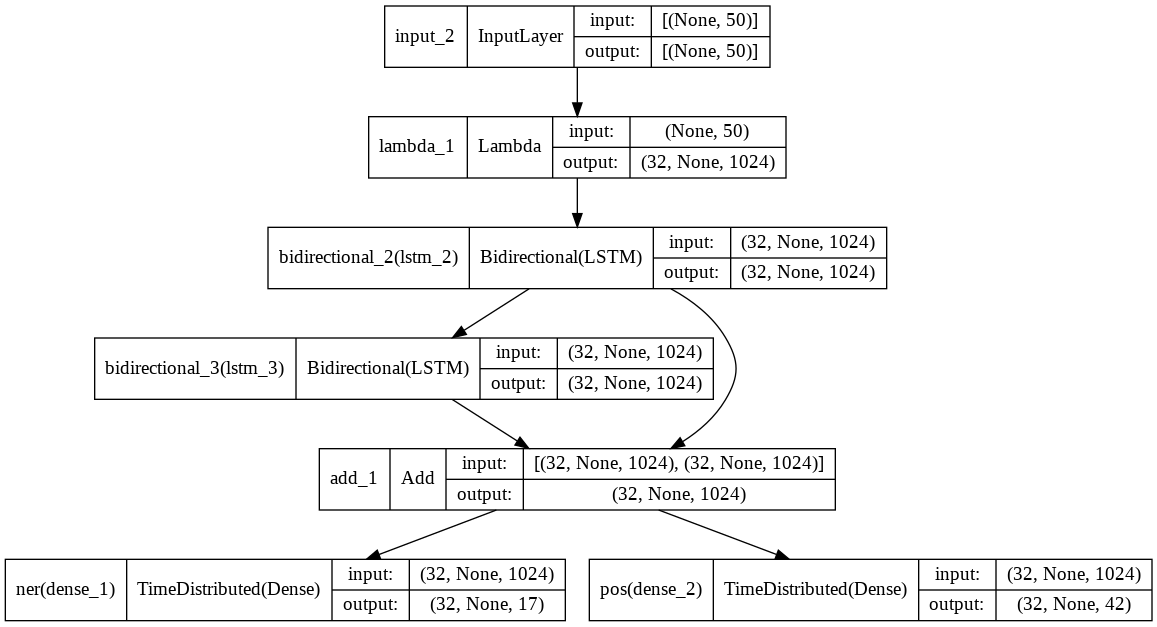

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(multitask_model,'Elmo_tag.png',show_shapes= True)